In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import *

##
# Read the different types of input
##

def readBitSeqFile(fn,suffix):
    df = pd.read_table(fn, sep='\s*',comment='#',
                     names = ['Name',
                              'Length_{}'.format(suffix),
                              'mean_theta{}'.format(suffix),
                              'alpha{}'.format(suffix),
                              'beta{}'.format(suffix)])
    df.set_index('Name', inplace=True)
    df.convert_objects(convert_numeric=True)
    return df 


def readRSEMTruth(fn, suffix=""):
    df = pd.read_csv(fn, sep='\t', skiprows=1,
                     names=['Name', 'Gene{}'.format(suffix),
                            'Length{}'.format(suffix),
                            'EffLength{}'.format(suffix),
                            'Count{}'.format(suffix),
                            'TPM{}'.format(suffix),
                            'FPKM{}'.format(suffix),
                            'IsoPct{}'.format(suffix)])
    df.set_index('Name', inplace=True)
    return df



def readSailfishQuasi(fn, suffix=""):
    df = pd.read_csv(fn, sep='\t', comment='#',
                     names=['Name',
                            'Length{}'.format(suffix),
                            'TPM{}'.format(suffix),
                            'NumReads{}'.format(suffix)])
    df.dropna(how='all', inplace=True)
    df.convert_objects(convert_numeric=True)
    df.set_index('Name', inplace=True)
    return df

def readKallisto(fn, suffix=""):
    df = pd.read_csv(fn, sep='\t', skiprows=1,
                     names=['Name',
                            'Length{}'.format(suffix),
                            'EffLen{}'.format(suffix),
                            'NumReads{}'.format(suffix),
                            'TPM{}'.format(suffix)])
    df.set_index('Name', inplace=True)
    df.convert_objects(convert_numeric=True)
    return df
v = 'TPM_norm'

In [29]:
RSEMTruth = readRSEMTruth("/mnt/scratch1/simulated_data/rsem_sim_data/11.sim.isoforms.results","_truth")
sailfishRSEM_EM = readSailfishQuasi('/mnt/scratch2/hirak/bitseq_results_all/SailfishEM/RSEM/quant.sf',"_sailfishEM")
kallistoRSEM = readKallisto('/mnt/scratch2/hirak/bitseq_results_all/Kallisto/RSEM/abundance.tsv','_kallisto')
BitseqVB = readBitSeqFile('/mnt/scratch2/hirak/bitseq_results_all/BitSeq_BowTie/RSEM/bitseq_bow_rsem.txt','_BVB')

In [30]:
m = RSEMTruth.join(sailfishRSEM_EM).join(kallistoRSEM).join(BitseqVB)

In [31]:
m['TPM_BVB'] = m['alpha_BVB'] / m['Length_truth']
m['TPM_BVB'] = m['TPM_BVB']/sum(m['TPM_BVB'])
m['TPM_BVB'] = m['TPM_BVB']*1000000
m['mean_theta_BVB'] = m['mean_theta_BVB'] / (1.0 - 6.387921070e-04)
m['TPM_BVB2'] = m['mean_theta_BVB'] / m['Length_truth']
m['TPM_BVB2'] = m['TPM_BVB2'] / m['TPM_BVB2'].sum()
m['TPM_BVB2'] *= 1000000

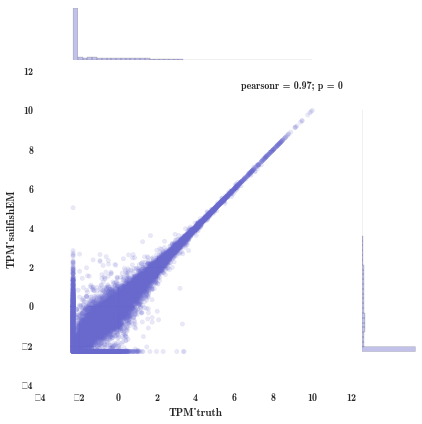

In [32]:
%matplotlib inline
import numpy as np
sns.jointplot(np.log(m['TPM_truth']+0.1), np.log(m['TPM_sailfishEM']+0.1), color=(0.4, 0.4, 0.8, 0.15))

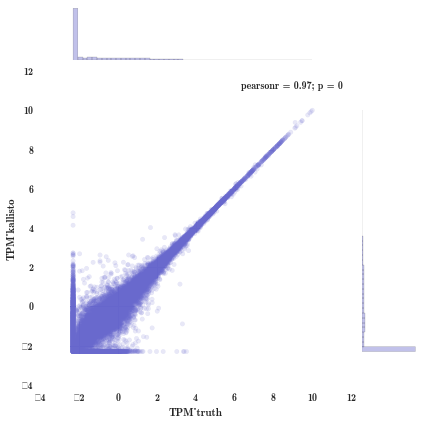

In [33]:
sns.jointplot(np.log(m['TPM_truth']+0.1), np.log(m['TPM_kallisto']+0.1),color=(0.4, 0.4, 0.8, 0.15))

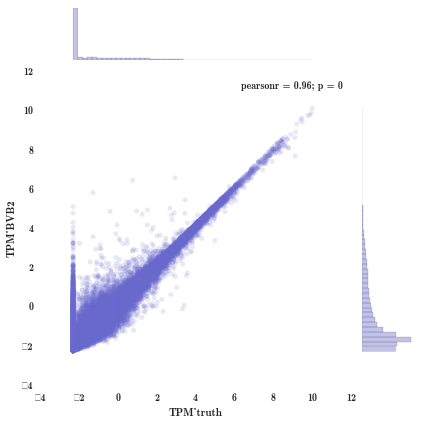

In [34]:
sns.jointplot(np.log(m['TPM_truth']+0.1), np.log(m['TPM_BVB2']+0.1),color=(0.4, 0.4, 0.8, 0.15))

In [35]:
rdict = {}

eps = 0.01
corrSFSpear = m['TPM_truth'].corr(m['TPM_sailfishEM'], 'spearman')
corrSFPearson = m['TPM_truth'].corr(m['TPM_sailfishEM'])
corrSFPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_sailfishEM']+eps))


corrKalSpear = m['TPM_truth'].corr(m['TPM_kallisto'], 'spearman')
corrKalPearson = m['TPM_truth'].corr(m['TPM_kallisto'])
corrKalPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_kallisto']+eps))


corrBVBSpear = m['TPM_truth'].corr(m['TPM_BVB2'], 'spearman')
corrBVBPearson = m['TPM_truth'].corr(m['TPM_BVB2'])
corrBVBPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_BVB2']+eps))


print("Spearman Correlation\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFSpear, corrKalSpear, corrBVBSpear))
print("\nPearson Correlation\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFPearson, corrKalPearson, corrBVBPearson))
print("\nPearson Correlation (log scale)\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFPearsonLog, corrKalPearsonLog, corrBVBPearsonLog))

Spearman Correlation
Sailfish (quasi) = 0.915535300386
Kallisto = 0.915115013779
BitSeqVB = 0.838078559118

Pearson Correlation
Sailfish (quasi) = 0.999915210733
Kallisto = 0.998936680087
BitSeqVB = 0.981274918874

Pearson Correlation (log scale)
Sailfish (quasi) = 0.945207124568
Kallisto = 0.945431424934
BitSeqVB = 0.915243868553


In [36]:
def ard(s1,s2):
    return ((abs(s1-s2))/(0.5*(abs(s1+s2))))

In [37]:
m['ard_sailfishEM'] = ard(m['TPM_truth'],m['TPM_sailfishEM'])
m['ard_sailfishEM'].fillna(0.0,inplace=True)

In [38]:
m['ard_kallisto'] = ard(m['TPM_truth'],m['TPM_kallisto'])
m['ard_kallisto'].fillna(0.0,inplace=True)

In [39]:
m['ard_BVB2'] = ard(m['TPM_truth'],m['TPM_BVB2'])
m['ard_BVB2'].fillna(0.0,inplace=True)

In [43]:
hist_ard = pd.DataFrame({'sailfishQuasi': m['ard_sailfishEM'],'Kallisto': m['ard_kallisto'],'BitSeq': m['ard_BVB2']},columns=['sailfishQuasi','Kallisto','BitSeq'])

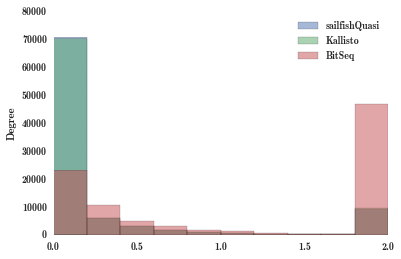

In [46]:
%matplotlib inline
plt.figure()
hist_ard.plot(kind='hist', alpha=0.5)


In [ ]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000),'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])

##Now we consider some MAE-related metrics

First, with a pseudo-count

In [32]:
indsSF = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']))
indsK = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_kallisto']))
indsBVB = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_bvb']))
indsAll = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']) & np.isfinite(m['test_log_kallisto']) & np.isfinite(m['test_log_bvb']))

m['TPM_truth_pseudo'] = m['TPM_truth'] + eps
m['TPM_sf_pseudo'] = m['TPM_sailfishEM'] + eps
m['TPM_kallisto_pseudo'] = m['TPM_kallisto'] + eps
m['TPM_bvb_pseudo'] = m['TPM_BVB'] + eps
m['truth_log_pseudo'] = log(m['TPM_truth_pseudo']/sum(m['TPM_truth_pseudo']))
m['test_log_sf_pseudo'] = log(m['TPM_sf_pseudo']/sum(m['TPM_sf_pseudo']))
m['test_log_kal_pseudo'] = log(m['TPM_kallisto_pseudo']/sum(m['TPM_kallisto_pseudo']))
m['test_log_bvb_pseudo'] = log(m['TPM_bvb_pseudo']/sum(m['TPM_bvb_pseudo']))

resSFPseudo = (m['truth_log_pseudo'] - m['test_log_sf_pseudo']).abs().mean()
resKPseudo= (m['truth_log_pseudo'] - m['test_log_kal_pseudo']).abs().mean()
resBVBPseudo = (m['truth_log_pseudo'] - m['test_log_bvb_pseudo']).abs().mean()

In [33]:
print("MAE where TPMs are given a pseudocount (0.01)\n================================================")
print("MAE (Sailfish) = {}\nMAE (Kallisto) = {}\nMAE (BitseqVB) = {}".format(resSFPseudo,  resKPseudo, resBVBPseudo))

MAE where TPMs are given a pseudocount (0.01)
MAE (Sailfish) = 0.34899929258
MAE (Kallisto) = 0.349861677166
MAE (BitseqVB) = 1.27977455543


Now, discarding transcripts not detected by each method 

In [53]:
m['truth_log'] = log(m['TPM_truth']/sum(m['TPM_truth']))
m['test_log_sf'] = log(m['TPM_sailfishEM']/sum(m['TPM_sailfishEM']))
m['test_log_kallisto'] = log(m['TPM_kallisto']/sum(m['TPM_kallisto']))
m['test_log_bvb'] = log(m['TPM_BVB2']/sum(m['TPM_BVB2']))

In [54]:
indsSF = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']))
indsK = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_kallisto']))
indsBVB = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_bvb']))
indsAll = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']) & np.isfinite(m['test_log_kallisto']) & np.isfinite(m['test_log_bvb'])) 
resSF = (m['truth_log'][indsSF] - m['test_log_sf'][indsSF]).abs().mean()
resK= (m['truth_log'][indsK] - m['test_log_kallisto'][indsK]).abs().mean()
resBVB = (m['truth_log'][indsBVB] - m['test_log_bvb'][indsBVB]).abs().mean()

In [55]:
print("MAE where infinite log(TPM)s are *excluded*\n==============================================")
print("MAE (Sailfish) = {}; # txps = {}\nMAE (Kallisto) = {}; #txps = {}\nMAE (BitseqVB) = {}; #txps = {}".format(\
                            resSF, len(indsSF[indsSF==True]), resK, len(indsK[indsK==True]), resBVB, len(indsBVB[indsBVB==True])))

MAE where infinite log(TPM)s are *excluded*
MAE (Sailfish) = 0.301660767278; # txps = 41856
MAE (Kallisto) = 0.352248122226; #txps = 42062
MAE (BitseqVB) = 0.356606499273; #txps = 46708


Finally, discarding transcripts not discovered by all methods


In [56]:
indsAll = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']) & np.isfinite(m['test_log_kallisto']) & np.isfinite(m['test_log_bvb'])) 
resSFIgnore = (m['truth_log'][indsAll] - m['test_log_sf'][indsAll]).abs().mean()
resKIgnore = (m['truth_log'][indsAll] - m['test_log_kallisto'][indsAll]).abs().mean()
resBVBIgnore = (m['truth_log'][indsAll] - m['test_log_bvb'][indsAll]).abs().mean()

In [57]:
print("MAE where txps missed by any method are discarded\n================================================")
print("MAE (Sailfish) = {}\nMAE (Kallisto) = {}\nMAE (BitseqVB) = {}".format(resSFIgnore,  resKIgnore, resBVBIgnore))

MAE where txps missed by any method are discarded
MAE (Sailfish) = 0.298447551627
MAE (Kallisto) = 0.274570251777
MAE (BitseqVB) = 0.320197202537
